In [2]:
# %pylab nbagg
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from lab_repo.classes.dbclasses import dbExperimentSet, dbExperiment
from lab_repo.classes.classes import pcExperimentGroup

import numpy as np
import scipy
from scipy.stats import pearsonr, binned_statistic, sem

import pandas as pd

from datetime import datetime

import lab_repo.analysis.dendrites_analysis as da
from lab_repo.misc.plotting import cdf


import cPickle as pkl
import os

import lab_repo.misc.plotting as lpl

In [3]:
def initializeExperimentGroup():

    pc_kwargs = {'imaging_label': 'mergedmerged',
                 'nPositionBins': 100,
                 'channel': 'Ch2',
                 'demixed': False,
                 'pf_subset': None,
                 'signal': 'spikes'}

    path = '/home/sebi/grps/dend_grp.json'
    eset = dbExperimentSet(project_name='sebi')
    grp = pcExperimentGroup.from_json(path, eset, **pc_kwargs)

    return grp

In [4]:
# grp = initializeExperimentGroup()

# Restrict to context 1
# grp = pcExperimentGroup([e for e in grp if e.condition == 1], **grp.args)

soma_filter = lambda x: '_' not in x.label
dend_filter = lambda x: '_' in x.label

In [5]:
def formatPlot(ax, offset=4):
    for axis in ['left', 'right', 'bottom', 'top']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=14, length=6, width=2)
    sns.despine(ax=ax, offset=offset)

In [1170]:
def parallel_sort(a, b, key=None, reverse=False):
    # Pass in key as sort you want to be applied to a
    # b will be sorted alongside a
    
    if key is None:
        new_key = None
    else:
        new_key = lambda x: key(x[0])
    
    a, b = zip(*sorted(zip(a, b), key=new_key, reverse=reverse))
    
    return list(a), list(b)

In [1169]:
def get_plane(roi):
    return roi.coords[0][0, 2]

def fix(sig, T=None, pct=None):
    
    if T is None:
        T = np.array(range(sig.shape[-1]))
    
    if pct is None:
        low = np.nanmin(sig[T])
        high = np.nanmax(sig[T])
    else:
        low = np.nanpercentile(sig[T], pct[0])
        high = np.nanpercentile(sig[T], pct[1])
    
    return (sig - low) / (high - low)

In [1171]:
def trans_array(trans, sig):
    
    newtrans = np.full((sig.shape), np.nan)
        
    for start, stop in zip(trans['start_indices'][0], trans['end_indices'][0]):

        newtrans[start:stop] = sig[start:stop]

    return newtrans

In [1379]:
swr_spikes = da.branch_spikes(grp, signal=None, non_running_only=True, ripple_only=True, include_failures=True)

<module 'lab.analysis.dendrites_analysis' from '/home/sebi/code/analysis/lab/analysis/dendrites_analysis.py'>

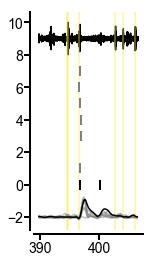

In [1674]:
# SWR Response Example 1
# Could expand to 2930 to show isolated spikes in subsequent ripple

expt = dbExperiment(10338)
cellid = 'cell01'
rois = expt.rois()
ridx = [i for i,r in enumerate(rois) if r.label.lower().startswith(cellid)]
idx = [i for i, r in enumerate(rois) if r.label.lower() == cellid][0]
sigs = expt.imagingData(dFOverF='from_file')
trans = expt.transientsData()

#frames to include
tstart = 2810
tstop = 2930

#corresponding lfp samples
rstart = expt.lfp_frames()[tstart * 3]
rstop = expt.lfp_frames()[tstop * 3]

rframes = expt.ripple_frames()
eegpath = glob(os.path.join(expt.LFPFilePath(), '*.xml'))[0][:-4]
eeg = lfp.loadEEG(eegpath)

ripple_channel = 1
lfp_segment = eeg['EEG'][ripple_channel, rstart:rstop]
fs = int(eeg['sampeFreq'])
lfpT = np.arange(len(lfp_segment)) / float(fs) + (tstart * expt.frame_period())

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(lfpT, normed(filter_signal(lfp_segment)) * 2 + len(ridx), 'k')


for rframe in set(rframes):
    if tstart <= rframe and rframe <= tstop:
        ax.axvline(rframe * expt.frame_period(), color='#feea2d', ls='-', alpha=0.5)

shift = 1
for trans_start in trans[idx]['start_indices'][0]:
    if tstart <= trans_start and trans_start <= tstop:
        ax.plot(trans_start * expt.frame_period(), 0, '|', color='k', ms=10, markeredgewidth=2) #1c76bc
ii = 0
for ri in ridx:
    if ri == idx:
        continue
    for trans_start in trans[ri]['start_indices'][0]:
        if tstart <= trans_start and trans_start <= tstop:  
            ax.plot(trans_start * expt.frame_period(), shift*(ii+1), '|', color='0.5', ms=10, markeredgewidth=2) 
    ii += 1
    
for ri in ridx:
    if ri == idx:
        continue
    ax.plot(np.arange(tstart, tstop) * expt.frame_period(), normed(sigs[ri, tstart:tstop, 0], False) / 6 - 2, color='0.5', alpha=0.5)
ax.plot(np.arange(tstart, tstop) * expt.frame_period(), normed(sigs[idx, tstart:tstop, 0], False) / 6 - 2, color='k', alpha=1)

formatPlot(ax)
ratio = 2
ax.set_aspect(ratio / ax.get_data_ratio())

fig.savefig('/home/sebi/plots/dends/swr_response_example.svg')

# Example Data by plane

In [1172]:
expt = [e for e in grp if '/data/Sebi/2p/svr021/061917/TSeries-06192017-002' in e.get('tSeriesDirectory')][0]

cell_filter = lambda x: x.label.split('_')[0].lower() == 'cell07'

rois = expt.rois(label='mergedmerged', roi_filter=cell_filter)
sigs = expt.imagingData(dFOverF='from_file', roi_filter=cell_filter)[:, :, 0]
spikes = expt.spikes(label='mergedmerged', roi_filter=cell_filter)
trans = expt.transientsData(label='mergedmerged', roi_filter=cell_filter)

rlabels = [r.label for r in rois]
planes = [get_plane(x) for x in rois]

planes, sort_idx = parallel_sort(planes, range(len(rlabels)), reverse=True)
soma_idx = [i for i, r in enumerate(rois) if '_' not in r.label][0]
new_soma_idx = sort_idx.index(soma_idx)

planes.insert(0, planes.pop(new_soma_idx))
sort_idx.insert(0, sort_idx.pop(new_soma_idx))

colors = ['#EC5E34', '#2BB673', '#1B75BC']

In [3045]:
rois = expt.rois(label='mergedmerged')

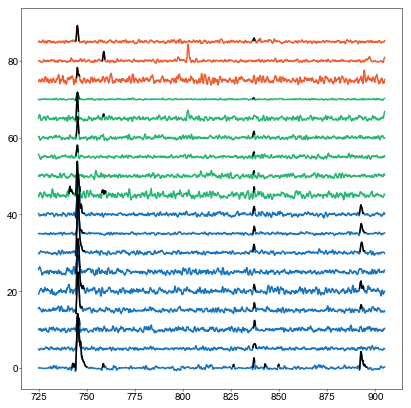

In [1185]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

fs = expt.frame_period()

T = np.array(range(int(725/fs), int(905/fs))) # Pretty good for 10653, cell 07


every_other = [0, 2, 4, 6, 8, 10, 11, 13, 15, 17]
count = 0

shift = 5

for i, (sig, spike, tran) in enumerate(zip(sigs[sort_idx, :], spikes[sort_idx, :], trans[sort_idx])):

    trans_sig = trans_array(tran, sig)
    T_shift = T
    
    ax.plot(T_shift * fs, sig[T] + count, color=colors[int(planes[i])], lw=1.5, zorder=-count);
    ax.plot(T_shift * fs, trans_sig[T] + count, color='k', lw=1.5, zorder=-count)
    
    count += shift

count = 0

ratio = 1
ax.set_aspect(ratio / ax.get_data_ratio())

fig.savefig('/home/sebi/plots/dends/example_cell_traces.svg')    

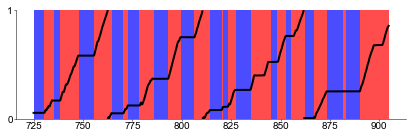

In [1190]:
pos = ba.absolutePosition(expt.find('trial'), imageSync=True) % 1

new_laps = np.hstack([0, np.abs(np.diff(pos)) > 0.5]).astype(bool)
pos[new_laps] = np.nan

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(111)


running = expt.runningIntervals(returnBoolList=True)[0]

transf = ax.get_xaxis_transform()
xra = np.c_[T[:-1],np.diff(T)]
ax.broken_barh(xra[running[T][:-1]] * fs, (0,1), 
                      facecolors='r', alpha=0.7, transform=transf)
ax.broken_barh(xra[~running[T][:-1]] * fs, (0,1), 
                      facecolors='b', alpha=0.7, transform=transf)

ax.plot(T_shift * fs, pos[T], 'k', lw=2)

ax.yaxis.set_ticks([0, 1])
ax.set_ylim([0, 1])
sns.despine(ax=ax)

fig.savefig('/home/sebi/plots/dends/running_trace.svg')

### LFP Example

In [1640]:
import scipy.signal as signal

def filter_signal(segment, fs=1250.):
    bHP, aHP=signal.butter(8, 100.*2/fs, btype="highpass", analog=False)

    bLP, aLP=signal.butter(8, 225.*2/fs, btype="lowpass", analog=False)


    dataF=signal.lfilter(bLP, aLP, segment)
    dataBP=signal.lfilter(bHP, aHP, dataF)
    
    return dataBP

expt = [x for x in grp if x.trial_id == 7364][0]

eegpath = glob(os.path.join(expt.LFPFilePath(), '*.xml'))[0][:-4]
eeg = lfp.loadEEG(eegpath)
ripple_times = expt.ripple_times()

ridx = 75

fs = int(eeg['sampeFreq'])

In [3464]:
ripple_stops = expt.ripple_times(trigger='tend')

In [3459]:
sig = mne.filter.band_pass_filter(eeg['EEG'].astype('float64'), 1250, 10, 600);

Band-pass filtering from 10 - 6e+02 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-3459-da0f73fd28cb>:1: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  sig = mne.filter.band_pass_filter(eeg['EEG'].astype('float64'), 1250, 10, 600);


In [3203]:
def normed(s):
    return (s - np.nanmin(s)) / (np.nanmax(s) - np.nanmin(s))

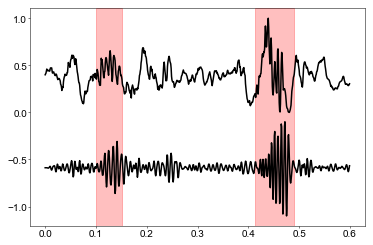

In [3478]:
fig = plt.figure()
ax = fig.add_subplot(111)

tpre = 0.1
tpost = 0.5

segment = sig[3, ripple_times[ridx] - int(tpre * fs): ripple_times[ridx] + int(tpost * fs)]

lfpT = np.arange(len(segment)) / float(fs)

ax.plot(lfpT, normed(segment), color='k')
ax.plot(lfpT, normed(filter_signal(segment)) - 1.1, 'k')

ax.axvspan(lfpT[int(tpre * fs)], lfpT[int(tpre * fs) + ripple_stops[ridx] - ripple_times[ridx]], color='r', alpha=0.25)
ax.axvspan(lfpT[int(tpre * fs) + ripple_times[ridx + 1] - ripple_times[ridx]], lfpT[int(tpre * fs) + ripple_stops[ridx + 1] - ripple_times[ridx]], color='r', alpha=0.25)

fig.savefig('/home/sebi/plots/dends/detected_swr_example.svg')